In [ ]:
a = 2251262626%15+1
a

In [2]:
import pandas as pd
import numpy as np

url = "/content/drive/MyDrive/Hoc_hanh/Time_Series/occupancy_data/datatraining.txt"
df_train = pd.read_csv(url)
df_train.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [3]:
df_train.shape

(8143, 7)

In [4]:
df_train.isnull().sum()

,0
date,0
Temperature,0
Humidity,0
Light,0
CO2,0
HumidityRatio,0
Occupancy,0


In [5]:
X = df_train[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']].values
y = df_train['Occupancy'].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [6]:
X

array([[2.51847007, 0.27852622, 1.57376283, 0.36494808, 1.09175697],
       [2.48896731, 0.27771261, 1.59173515, 0.34188106, 1.08055497],
       [2.48896731, 0.27364453, 1.57376283, 0.34029023, 1.07588816],
       ...,
       [0.47294534, 1.87375407, 1.60970748, 0.61073113, 2.03352707],
       [0.47294534, 1.90358662, 1.60970748, 0.68019732, 2.063811  ],
       [0.47294534, 1.89273842, 1.68159679, 0.68231843, 2.05279837]])

In [7]:
state_means = {
    0: X[y == 0].mean(axis=0),
    1: X[y == 1].mean(axis=0)
}

In [8]:
state_means

{0: array([-0.27944259, -0.06903477, -0.47109541, -0.36979112, -0.15590561]),
 1: array([1.03663666, 0.25609544, 1.74760322, 1.37179886, 0.5783566 ])}

In [9]:
def transition_fn(state):
    return state if np.random.rand() > 0.1 else 1 - state

def observation_fn(state):
    return state_means[state]

In [10]:
class ParticleFilter:
    def __init__(self, num_particles, transition_fn, observation_fn, obs_noise_std=0.5):
        self.num_particles = num_particles
        self.particles = np.random.choice([0, 1], size=num_particles)
        self.weights = np.ones(num_particles) / num_particles
        self.transition_fn = transition_fn
        self.observation_fn = observation_fn
        self.obs_noise_std = obs_noise_std

    def predict(self):
        self.particles = np.array([self.transition_fn(p) for p in self.particles])

    def update(self, observation):
        for i, p in enumerate(self.particles):
            pred_obs = self.observation_fn(p)
            self.weights[i] = np.exp(-np.linalg.norm(pred_obs - observation)**2 / (2 * self.obs_noise_std**2))
        self.weights += 1e-300
        self.weights /= np.sum(self.weights)

    def resample(self):
        indices = np.random.choice(self.num_particles, size=self.num_particles, p=self.weights)
        self.particles = self.particles[indices]
        self.weights = np.ones(self.num_particles) / self.num_particles

    def estimate(self):
        return int(np.round(np.sum(self.particles * self.weights)))

# ***TRAIN***

In [11]:
pf = ParticleFilter(num_particles=100, transition_fn=transition_fn, observation_fn=observation_fn)

predictions = []
for i in range(len(X)):
    pf.predict()
    pf.update(X[i])
    pf.resample()
    predictions.append(pf.estimate())

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

acc = accuracy_score(y, predictions)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9472


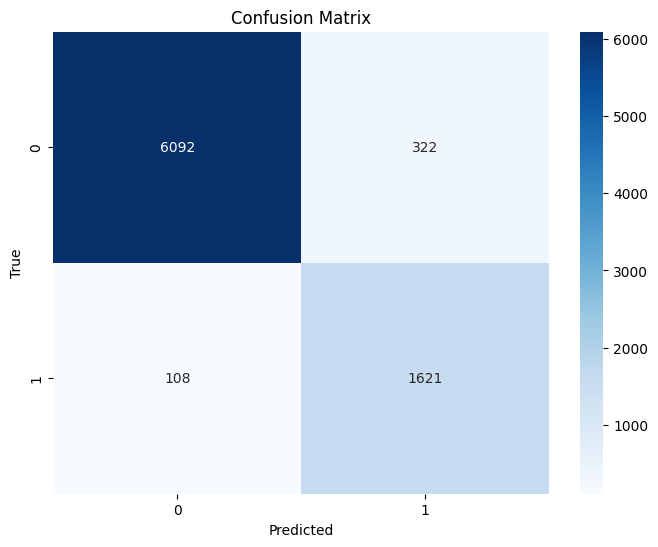

In [18]:
cm = confusion_matrix(y, predictions)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(0,2), yticklabels=np.arange(0,2))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ***TEST***

In [13]:
test_file = "/content/drive/MyDrive/Hoc_hanh/Time_Series/occupancy_data/datatest.txt"
test_df = pd.read_csv(test_file)
test_df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [14]:
X_test = test_df[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']].values
y_test = test_df['Occupancy'].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

In [15]:
predictions_test = []
for i in range(len(X_test)):
    pf.predict()
    pf.update(X_test[i])
    pf.resample()
    predictions_test.append(pf.estimate())

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

acc = accuracy_score(y_test, predictions_test)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9013


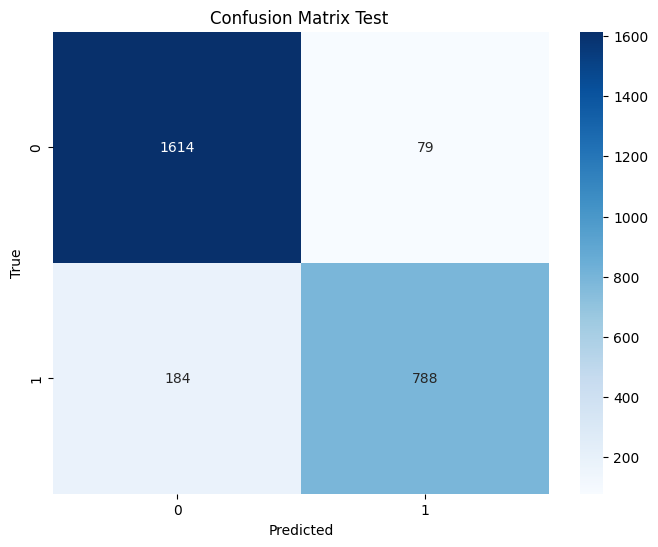

In [19]:
cm = confusion_matrix(y_test, predictions_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(0,2), yticklabels=np.arange(0,2))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Test ")
plt.show()